
<h1><center> NLP Final Project

Multi-Label Text classification

#Efi Herbst (ID. 039468319), Gal Blecher (ID. 201566304)</center></h1>




Net #1

In this notebook the network parameters are:

max length: 512.

batch size: 10.

Bert version: regular.

Training the whole weights.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.2MB/s 
     |████████████████████████████████| 901kB 50.0MB/s 
     |████████████████████████████████| 3.3MB 46.5MB/s 


In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import BertModel, BertConfig
import torch
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, TensorDataset, RandomSampler, SequentialSampler, random_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device('cuda')

#Data preperation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP project/Train.csv')
sentences = df['text'].values.tolist()
labels = np.array(df['label'])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                    
                        add_special_tokens = True,
                        max_length = 512,           
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',
                   ) 
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

28000 training samples
12000 validation samples


In [ ]:
batch_size = 10
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
            )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
            )

#Model definition

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,  
    output_attentions = False, 
    output_hidden_states = False,
)

model.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

In [ ]:
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# To solve some issues with cuda. sometimes help.
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()

#Training

In [ ]:
seed_val = 42
num_labels = 2

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

model.train()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = (batch[2].to(device)).long()
        one_hot = torch.zeros(batch_size, num_labels)
        one_hot[torch.arange(batch_size), b_labels] = 1
        b_labels = one_hot.to(device)

        model.zero_grad()
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
        
        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    training_time = format_time(time.time() - t0)
    print(f"  Training epcoh took: {training_time}")
    

    # ========================================
    #               Train loss
    # ========================================
    print("")
    print('Calculating training loss')

    t0 = time.time()
    model.eval()

    total_train_accuracy = 0
    total_train_loss = 0
    nb_train_steps = 0

    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()
        one_hot = torch.zeros(batch_size, num_labels)
        one_hot[torch.arange(batch_size), b_labels] = 1
        b_labels = one_hot.to(device)

        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += accuracy(logits, label_ids)

    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_loss = total_train_loss / len(train_dataloader)   

    print("")
    print(f"  Average training loss: {avg_train_loss}")
    
    
        
    # ========================================
    #               Validation loss
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()
        one_hot = torch.zeros(batch_size, num_labels)
        one_hot[torch.arange(batch_size), b_labels] = 1
        b_labels = one_hot.to(device)

        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print(f"  Validation Loss: {avg_val_loss}")
    print(f"  Validation took: {validation_time}")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch 40  of  2800.    Elapsed: 0:00:23.
  Batch 80  of  2800.    Elapsed: 0:00:46.
  Batch 120  of  2800.    Elapsed: 0:01:09.
  Batch 160  of  2800.    Elapsed: 0:01:32.
  Batch 200  of  2800.    Elapsed: 0:01:55.
  Batch 240  of  2800.    Elapsed: 0:02:18.
  Batch 280  of  2800.    Elapsed: 0:02:42.
  Batch 320  of  2800.    Elapsed: 0:03:05.
  Batch 360  of  2800.    Elapsed: 0:03:28.
  Batch 400  of  2800.    Elapsed: 0:03:51.
  Batch 440  of  2800.    Elapsed: 0:04:14.
  Batch 480  of  2800.    Elapsed: 0:04:37.
  Batch 520  of  2800.    Elapsed: 0:05:00.
  Batch 560  of  2800.    Elapsed: 0:05:23.
  Batch 600  of  2800.    Elapsed: 0:05:46.
  Batch 640  of  2800.    Elapsed: 0:06:09.
  Batch 680  of  2800.    Elapsed: 0:06:32.
  Batch 720  of  2800.    Elapsed: 0:06:55.
  Batch 760  of  2800.    Elapsed: 0:07:18.
  Batch 800  of  2800.    Elapsed: 0:07:41.
  Batch 840  of  2800.    Elapsed: 0:08:04.
  Batch 880  of  2800.    Elapsed: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.



  Average training loss: 0.11711823948725526

Running Validation...
  Accuracy: 0.0
  Validation Loss: 0.2199558233182567
  Validation took: 0:03:47

======== Epoch 2 / 2 ========
Training...
  Batch 40  of  2800.    Elapsed: 0:00:22.
  Batch 80  of  2800.    Elapsed: 0:00:45.
  Batch 120  of  2800.    Elapsed: 0:01:07.
  Batch 160  of  2800.    Elapsed: 0:01:29.
  Batch 200  of  2800.    Elapsed: 0:01:52.
  Batch 240  of  2800.    Elapsed: 0:02:14.
  Batch 280  of  2800.    Elapsed: 0:02:36.
  Batch 320  of  2800.    Elapsed: 0:02:59.
  Batch 360  of  2800.    Elapsed: 0:03:21.
  Batch 400  of  2800.    Elapsed: 0:03:43.
  Batch 440  of  2800.    Elapsed: 0:04:06.
  Batch 480  of  2800.    Elapsed: 0:04:28.
  Batch 520  of  2800.    Elapsed: 0:04:50.
  Batch 560  of  2800.    Elapsed: 0:05:13.
  Batch 600  of  2800.    Elapsed: 0:05:35.
  Batch 640  of  2800.    Elapsed: 0:05:57.
  Batch 680  of  2800.    Elapsed: 0:06:19.
  Batch 720  of  2800.    Elapsed: 0:06:42.
  Batch 760  of  

#Save/Load model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/NLP project/tuned_bert_2_epoches_2_labels.pt')

In [ ]:
model = model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,  
    output_attentions = False, 
    output_hidden_states = False,
)
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP project/tuned_bert_2_epoches_2_labels.pt'))
model.eval();

#Training validation plot

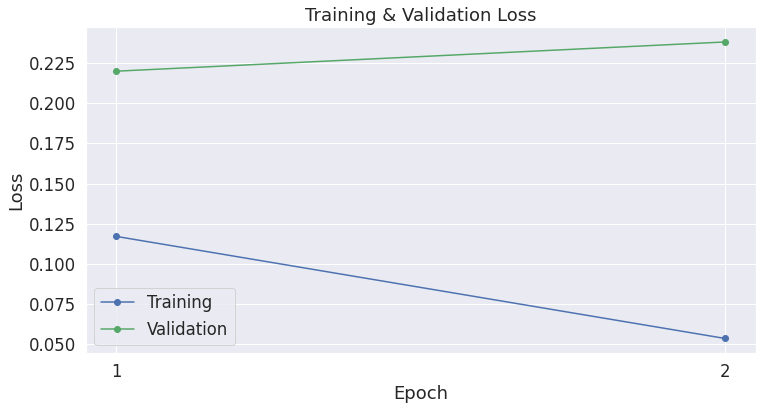

In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4])

plt.show()

#Test

In [ ]:
df_t = pd.read_csv('/content/drive/MyDrive/NLP project/Test.csv')
sentences_t = df_t['text'].values.tolist()

In [ ]:
labels_t = np.array(df_t['label'])

In [ ]:
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], sentences_t))

In [ ]:
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

In [ ]:
inputs_t = []

for i in range(len(test_tokens_ids)):
  inp = np.array(test_tokens_ids[i])
  delta = 512 - inp.shape[0] - 1
  sep = np.array([102])
  if delta > 0:
    input_ = np.concatenate((inp, sep, np.zeros(delta)), axis=0).astype('int')
    inputs_t.append(input_)
  else:
    input_ = np.concatenate((inp[:511], sep), axis=0).astype('int')
    inputs_t.append(input_)
inputs_t = torch.Tensor(inputs_t).to(torch.int64)

In [ ]:
BATCH_SIZE = 10
test_tokens_tensor = torch.tensor(inputs_t)
test_y_tensor = torch.tensor(labels_t.reshape(-1, 1)).float()
test_dataset = TensorDataset(test_tokens_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
def acc(net, loader):
    correct = 0
    total = 0
    all_preds = []
    all_lab = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            labels = labels.item()
            inputs = inputs.to(device)
            labels = labels
            outputs = net(inputs.unsqueeze(0))
            outputs = outputs.logits.cpu().numpy()
            predicted = np.argmax(outputs, axis=1).flatten().item()
            total += 1
            if predicted == labels:
              correct += 1
            all_preds.append(predicted)
            all_lab.append(labels)
    print('Accuracy of the network on the test reviews: %d %%' % (100 * correct / total))
    return all_lab, all_preds

In [ ]:
all_lab, all_preds = acc(model ,test_dataset)

Accuracy of the network on the test reviews: 93 %


In [ ]:
pd.DataFrame(confusion_matrix(all_lab, all_preds))

,0,1
0,2343,152
1,185,2320


#Reduce Dimension

In [ ]:
class Rev2VecBert(nn.Module):
    def __init__(self, layer):
        super(Rev2VecBert, self).__init__()
        self.features = nn.Sequential(
            *list(model.bert.children())[:layer]
        )
    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
model.cuda()
loader = test_tokens_tensor.cuda()
net = Rev2VecBert(-1)
vecs = {}
with torch.no_grad():
    for i, data in enumerate(loader):
      outputs = net(data.unsqueeze(0))
      vecs[i] = outputs[0][-1][0].cpu().numpy()

In [ ]:
d = np.array(list(vecs.values()))
d = d.squeeze()

In [ ]:
from sklearn.manifold import TSNE
vecs2d = TSNE(n_components=2, n_iter=2_000, perplexity=5.0).fit_transform(d)

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0).fit(vecs2d)

In [ ]:
gmm_classes = gm.predict(vecs2d).reshape(-1, 1)
centers = gm.means_

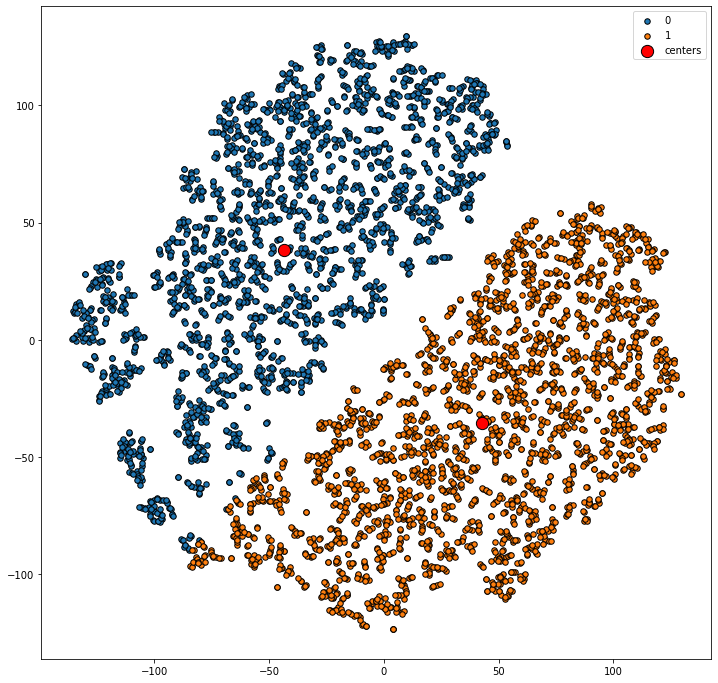

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(gmm_classes))
df = pd.DataFrame(np.concatenate((vecs2d, gmm_classes), axis = 1))
for n in np.unique(gmm_classes):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

In [ ]:
gmm_classes.sum()

2550

In [ ]:
gmm_classes.shape

(5000, 1)

In [ ]:
test_y_tensor.size()

torch.Size([5000, 1])

In [ ]:
test_y_tensor.sum()

tensor(2505.)

In [ ]:
test_y_tensor==gmm_classes

False

In [ ]:
test_y = test_y_tensor.numpy()

In [ ]:
sum(test_y != gmm_classes)/test_y.shape[0]

array([0.921])

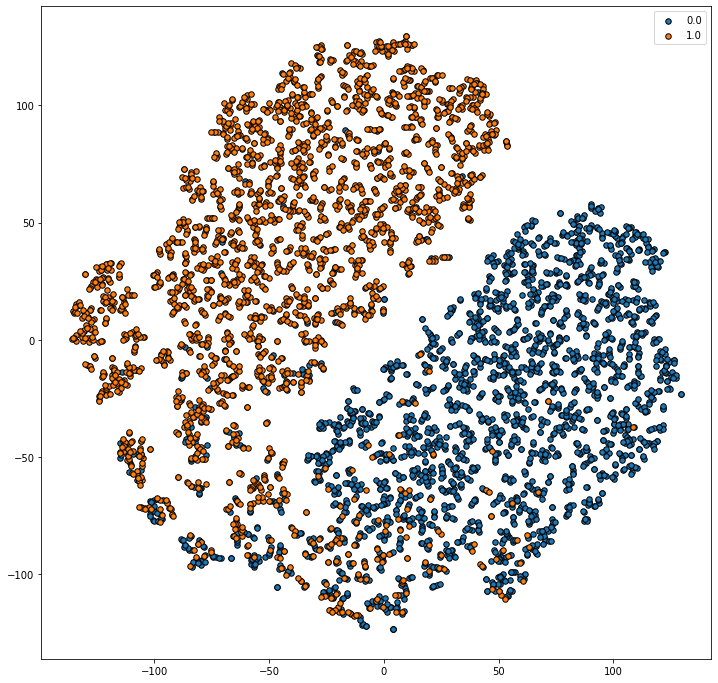

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(test_y))
df = pd.DataFrame(np.concatenate((vecs2d, test_y), axis = 1))
for n in np.unique(test_y):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
# plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

## Try to run different dataset with different labels

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP project/3 labels data/Twitter_Data.csv')
sentences = df['clean_text'].values.tolist()
labels_ = np.array(df['category'])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
input_ids = []
attention_masks = []

for i, sent in enumerate(sentences):
  try:
    encoded_dict = tokenizer.encode_plus(
                        sent,                    
                        add_special_tokens = True,
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',
                   ) 
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
  except:
    continue
  if i == 40_000:
    break
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset = TensorDataset(input_ids, attention_masks)
train_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

8598 training samples
8599 validation samples


In [ ]:
class Rev2VecBert(nn.Module):
    def __init__(self, layer):
        super(Rev2VecBert, self).__init__()
        self.features = nn.Sequential(
            *list(model.bert.children())[:layer]
        )
    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
loader = val_dataset.dataset
net = Rev2VecBert(-1)
vecs = {}
with torch.no_grad():
    for i, data in enumerate(loader):
      outputs = net(data[0].unsqueeze(0).cuda())
      vecs[i] = outputs[0][-1][0].cpu().numpy()

In [ ]:
d = np.array(list(vecs.values()))
d = d.squeeze()

In [ ]:
from sklearn.manifold import TSNE
vecs2d = TSNE(n_components=2, n_iter=2_000, perplexity=5.0).fit_transform(d)

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=0).fit(vecs2d)

In [ ]:
gmm_classes = gm.predict(vecs2d).reshape(-1, 1)
centers = gm.means_

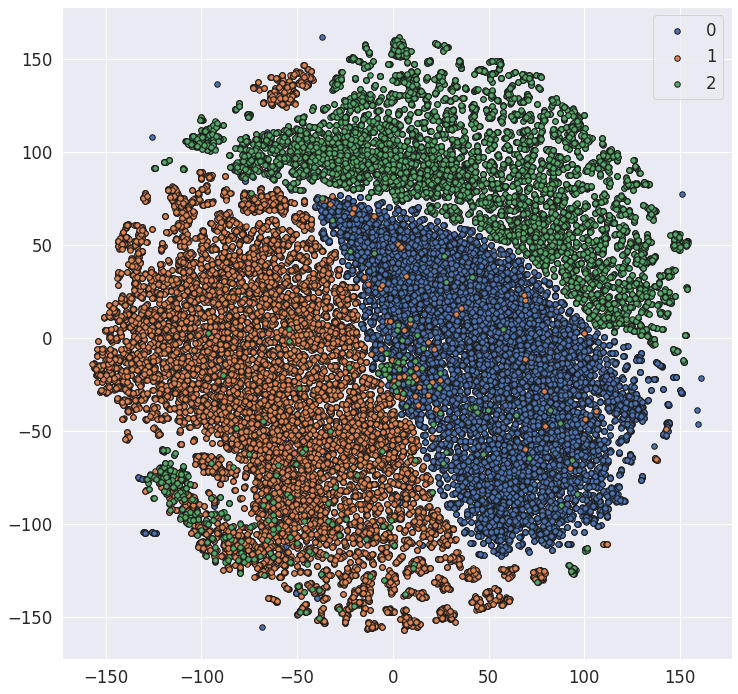

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(gmm_classes))
df = pd.DataFrame(np.concatenate((vecs2d, labels.numpy().reshape(-1,1)), axis = 1))
for n in np.unique(gmm_classes):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
# plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=100, min_samples=500).fit(vecs2d)
np.unique(dbscan.labels_)

array([0])

In [ ]:
gmm_classes = gm.predict(vecs2d).reshape(-1, 1)
centers = gm.means_

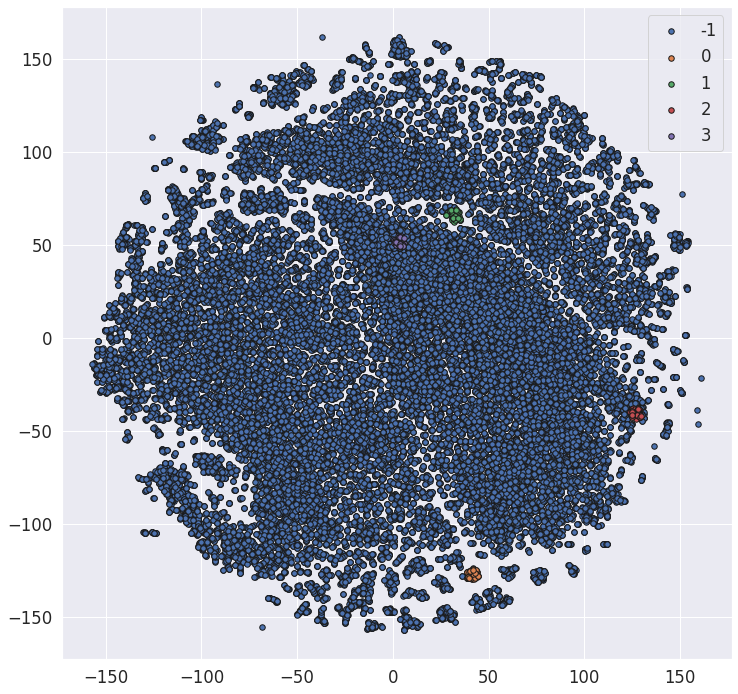

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(dbscan.labels_))
df = pd.DataFrame(np.concatenate((vecs2d, dbscan.labels_.reshape(-1,1)), axis = 1))
for n in np.unique(dbscan.labels_):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
# plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

In [ ]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(vecs2d, labels)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [ ]:
knn_classes = clf.predict(vecs2d)
centers = clf.centroids_

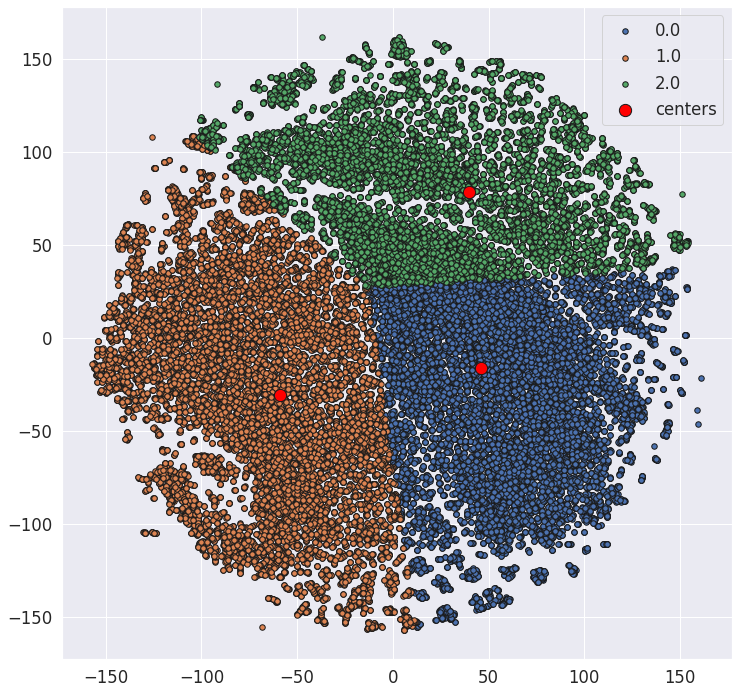

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(knn_classes))
df = pd.DataFrame(np.concatenate((vecs2d, knn_classes.reshape(-1,1)), axis = 1))
for n in np.unique(knn_classes):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

#Unsuccessful tries

#similarity

#BM

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP project/Train.csv')

In [ ]:
neg_samples = df[df['label'] == 0].sample(n=100, random_state=1)

In [ ]:
pos_samples = df[df['label'] == 1].sample(n=100, random_state=1)

In [ ]:
banch_mark = pd.concat([neg_samples,pos_samples])

In [ ]:
bm_sentences = banch_mark['text'].values.tolist()
bm_labels_ = np.array(banch_mark['label'])

In [ ]:
banch_mark.shape

(200, 2)

In [ ]:
len(bm_sentences)

200

In [ ]:
input_ids_bm = []
attention_masks_bm = []
labels_bm = []

for i, sent in enumerate(bm_sentences):
  try:
    encoded_dict = tokenizer.encode_plus(
                        sent,                    
                        add_special_tokens = True,
                        max_length = 512,           
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',
                   ) 
    input_ids_bm.append(encoded_dict['input_ids'])
    attention_masks_bm.append(encoded_dict['attention_mask'])
    labels_bm.append(bm_labels_[i])
  except:
    continue
  if i == 40_000:
    break
input_ids_bm = torch.cat(input_ids_bm, dim=0)
attention_masks_bm = torch.cat(attention_masks_bm, dim=0)
labels_bm = torch.tensor(labels_bm)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids_bm.size(), attention_masks_bm.size()

(torch.Size([200, 512]), torch.Size([200, 512]))

In [ ]:
dataset_bm = TensorDataset(input_ids_bm, attention_masks_bm)
train_size_bm = int(1.0 * len(dataset))
val_size_bm = len(dataset) - train_size
# train_dataset_bm, val_dataset_bm = random_split(dataset_bm, [train_size_bm, val_size_bm])
train_dataset_bm = dataset_bm

In [ ]:
class Rev2VecBert(nn.Module):
    def __init__(self, layer):
        super(Rev2VecBert, self).__init__()
        self.features = nn.Sequential(
            *list(model.bert.children())[:layer]
        )
    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
loader = train_dataset_bm
net = Rev2VecBert(-1)
vecs_bm = {}
with torch.no_grad():
    for i, data in enumerate(loader):
      outputs = net(data[0].unsqueeze(0).cuda())
      vecs_bm[i] = outputs[0][-1][0].cpu().numpy()

In [ ]:
len(vecs_bm)

200

#Comparing *to*

In [ ]:
new_df = pd.read_csv('/content/drive/MyDrive/NLP project/3 labels data/Twitter_Data.csv')
sentences = new_df['clean_text'].values.tolist()
labels_ = np.array(new_df['category'])

In [ ]:
input_ids = []
attention_masks = []
labels = []

for i, sent in enumerate(sentences):
  try:
    encoded_dict = tokenizer.encode_plus(
                        sent,                    
                        add_special_tokens = True,
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',
                   ) 
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    labels.append(labels_[i])
  except:
    continue
  if i == 40_000:
    break
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids.size(), attention_masks_bm.size()

(torch.Size([31962, 64]), torch.Size([200, 64]))

In [ ]:
dataset = TensorDataset(input_ids, attention_masks,labels)
train_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

4000 training samples
36000 validation samples


In [ ]:
loader = train_dataset
net = Rev2VecBert(-1)
vecs_comp = {}
with torch.no_grad():
    for i, data in enumerate(loader):
      outputs = net(data[0].unsqueeze(0).cuda())
      # print(i)
      # print(outputs[0][-1][0].cpu().numpy().reshape(-1,1).shape)
      # break
      vecs_comp[i] = outputs[0][-1][0].cpu().numpy().reshape(1,-1)

In [ ]:
len(vecs_comp)

4000

In [ ]:
len(vecs_bm)

200

In [ ]:
similarity_matrix = np.zeros((len(vecs_comp), len(vecs_bm)))
for i in range(len(vecs_comp)):
  x1 = vecs_comp[i]
  for j in range(len(vecs_bm)):
    x2 = vecs_bm[j]
    similarity_matrix[i,j] = (np.dot(x1, x2))/(np.linalg.norm(x1)*np.linalg.norm(x2))

In [ ]:
similarity_matrix.shape

(4000, 200)

In [ ]:
from sklearn.manifold import TSNE
vecs2d = TSNE(n_components=2, n_iter=2_000, perplexity=5.0).fit_transform(similarity_matrix)

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=0).fit(vecs2d)

In [ ]:
gmm_classes = gm.predict(vecs2d).reshape(-1, 1)
centers = gm.means_

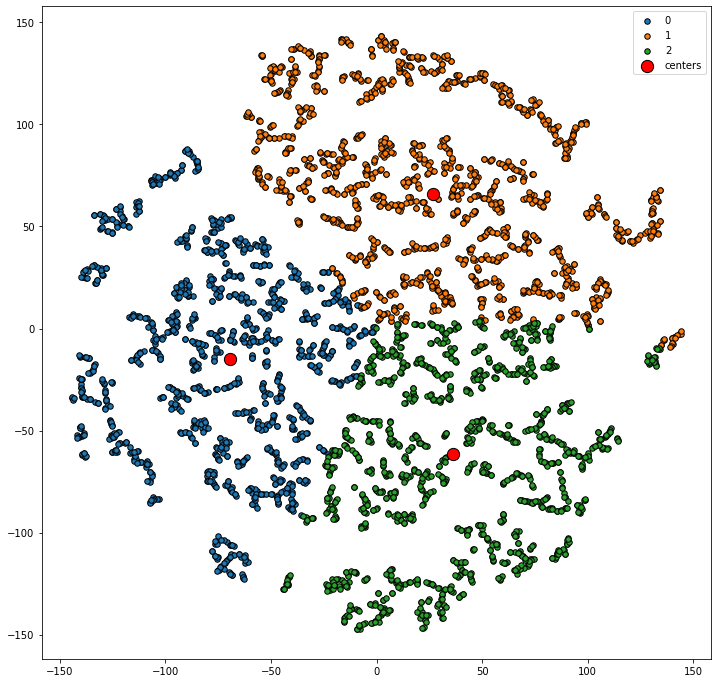

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(gmm_classes))
df = pd.DataFrame(np.concatenate((vecs2d, gmm_classes), axis = 1))
for n in np.unique(gmm_classes):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(gmm_classes))
df = pd.DataFrame(np.concatenate((vecs2d, gmm_classes), axis = 1))
for n in np.unique(gmm_classes):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

In [ ]:
train_labels = []
for i in range(len(train_dataset)):
  train_labels.append(train_dataset[i][2].numpy())

In [ ]:
len(train_labels)

3196

In [ ]:
train_labels = np.array(train_labels)

In [ ]:
train_labels.sum()

223

In [ ]:
train_labels.shape

(3196,)

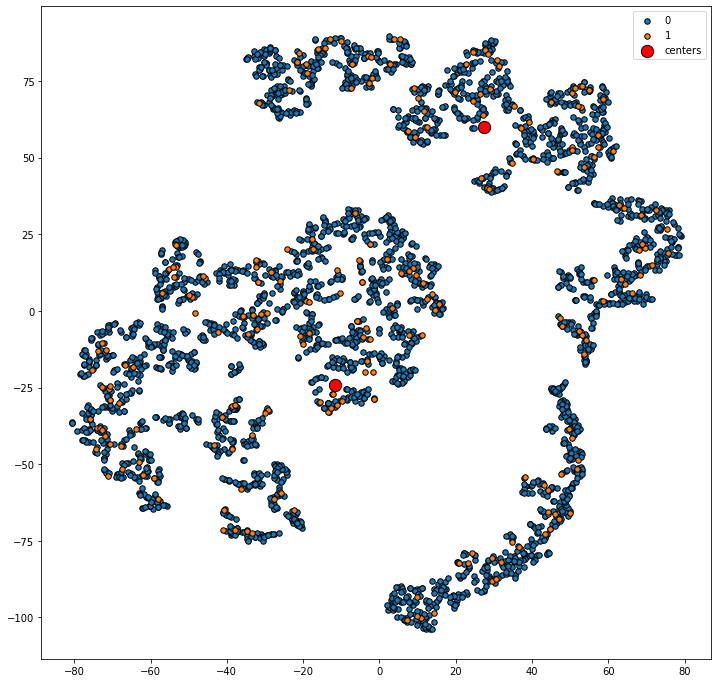

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(train_labels))
df = pd.DataFrame(np.concatenate((vecs2d, train_labels.reshape(-1,1)), axis = 1))
for n in np.unique(train_labels):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

In [ ]:
new_df = pd.read_csv('/content/drive/MyDrive/NLP project/train sexist.csv')
sentences = new_df['tweet'].values.tolist()
labels_ = np.array(new_df['label'])

In [ ]:
input_ids = []
attention_masks = []
labels = []

for i, sent in enumerate(sentences):
  try:
    encoded_dict = tokenizer.encode_plus(
                        sent,                    
                        add_special_tokens = True,
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',
                   ) 
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    labels.append(labels_[i])
  except:
    continue
  if i == 40_000:
    break
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids.size(), attention_masks_bm.size()

(torch.Size([31962, 64]), torch.Size([200, 64]))

In [ ]:
dataset = TensorDataset(input_ids, attention_masks,labels)
train_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

3196 training samples
28766 validation samples


In [ ]:
loader = train_dataset
net = Rev2VecBert(-1)
vecs_comp = {}
with torch.no_grad():
    for i, data in enumerate(loader):
      outputs = net(data[0].unsqueeze(0).cuda())
      # print(i)
      # print(outputs[0][-1][0].cpu().numpy().reshape(-1,1).shape)
      # break
      vecs_comp[i] = outputs[0][-1][0].cpu().numpy().reshape(1,-1)

In [ ]:
len(vecs_comp)

3196

In [ ]:
len(vecs_bm)

200

In [ ]:
similarity_matrix = np.zeros((len(vecs_comp), len(vecs_bm)))
for i in range(len(vecs_comp)):
  x1 = vecs_comp[i]
  for j in range(len(vecs_bm)):
    x2 = vecs_bm[j]
    similarity_matrix[i,j] = (np.dot(x1, x2))/(np.linalg.norm(x1)*np.linalg.norm(x2))

In [ ]:
similarity_matrix.shape

(3196, 200)

In [ ]:
# d = np.array(list(similarity_matrix.values()))
# d = d.squeeze()

In [ ]:
d.shape

(31962, 200)

In [ ]:
from sklearn.manifold import TSNE
vecs2d = TSNE(n_components=2, n_iter=2_000, perplexity=20.0).fit_transform(similarity_matrix)

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0).fit(vecs2d)

In [ ]:
gmm_classes = gm.predict(vecs2d).reshape(-1, 1)
centers = gm.means_

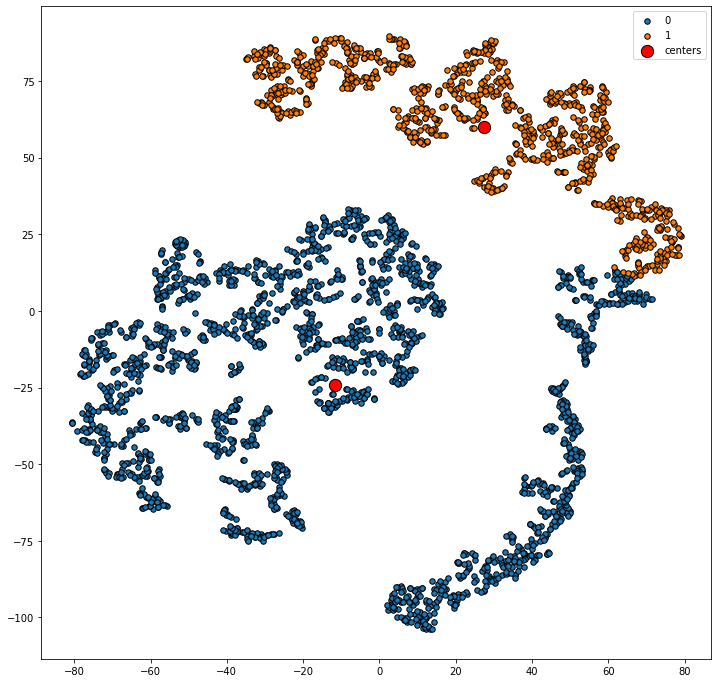

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(gmm_classes))
df = pd.DataFrame(np.concatenate((vecs2d, gmm_classes), axis = 1))
for n in np.unique(gmm_classes):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(gmm_classes))
df = pd.DataFrame(np.concatenate((vecs2d, gmm_classes), axis = 1))
for n in np.unique(gmm_classes):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()

In [ ]:
train_labels = []
for i in range(len(train_dataset)):
  train_labels.append(train_dataset[i][2].numpy())

In [ ]:
len(train_labels)

3196

In [ ]:
train_labels = np.array(train_labels)

In [ ]:
train_labels.sum()

223

In [ ]:
train_labels.shape

(3196,)

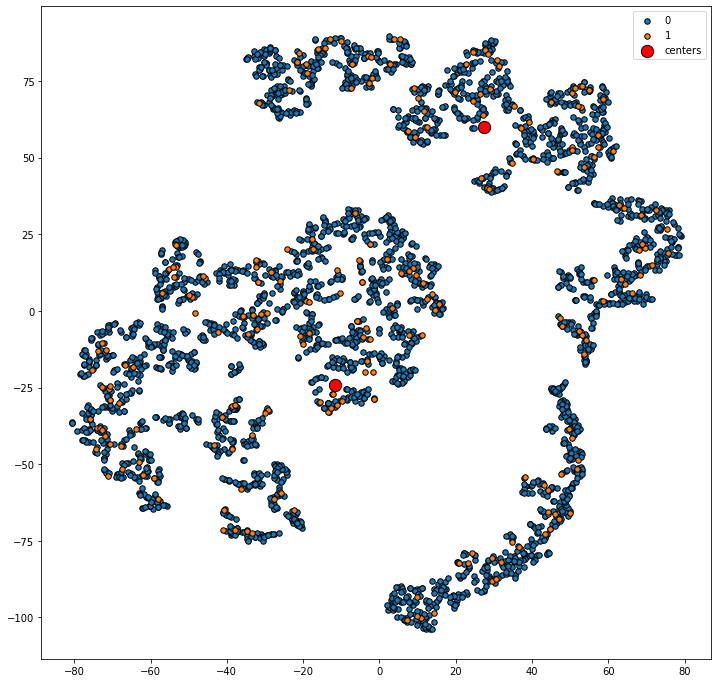

In [ ]:
plt.figure(figsize=(12,12))
Nc = len(np.unique(train_labels))
df = pd.DataFrame(np.concatenate((vecs2d, train_labels.reshape(-1,1)), axis = 1))
for n in np.unique(train_labels):
    plt.scatter(df[df[2] == n][0], df[df[2] == n][1], label = n, s=30, edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, label = 'centers', edgecolor='k')
plt.legend()